In [47]:
import pandas as pd

# Загрузка данных
df = pd.read_csv(r'C:\Users\kettl\Downloads\swiss-dwellings-v3.0.0\swiss-dwellings-v3.0.0\location_ratings.csv')

# Проверка данных
print(df.head())

# Создание нового атрибута - среднего рейтинга
rating_columns = [
    'location_rating_MIKRAT_W',
    'location_rating_IMAGE_W',
    'location_rating_DL_W',
    'location_rating_NASE_W_DOM',
    'location_rating_FGFRQZ'
]

# Рассчитываем средний рейтинг
df['average_location_rating'] = df[rating_columns].mean(axis=1)

# Просмотр обновленных данных
print(df.head())

   building_id  location_rating_MIKRAT_W  location_rating_IMAGE_W  \
0          826                       3.8                      4.1   
1        16314                       4.3                      4.1   
2         3261                       3.6                      3.0   
3          747                       3.6                      3.0   
4         1853                       3.4                      3.0   

   location_rating_FZ_W  location_rating_DL_W  location_rating_NASE_W_DOM  \
0                   4.0                   3.0                         9.0   
1                   3.0                   5.0                         9.0   
2                   4.0                   2.0                         5.0   
3                   4.1                   4.0                         2.0   
4                   4.0                   4.0                         3.0   

   location_rating_FGFRQZ  
0                     1.0  
1                     1.0  
2                     1.0  
3         

In [49]:
# Проверяем количество пропущенных значений
print(df.isnull().sum())

df = df.dropna()

building_id                    0
location_rating_MIKRAT_W       4
location_rating_IMAGE_W        4
location_rating_FZ_W           4
location_rating_DL_W           4
location_rating_NASE_W_DOM    40
location_rating_FGFRQZ         5
average_location_rating        4
dtype: int64


In [11]:
# Проверяем на дубликаты
print(df.duplicated().sum())

# Удаляем дубликаты
df = df.drop_duplicates()

0


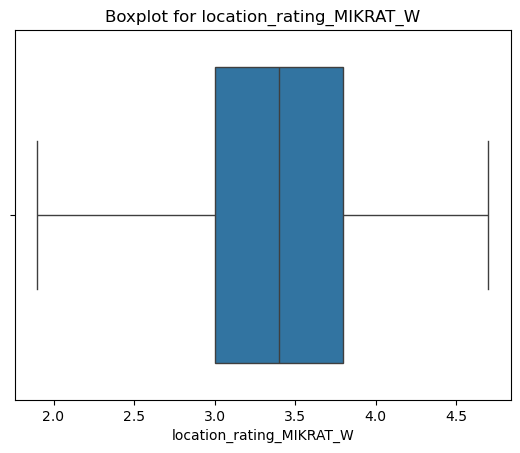

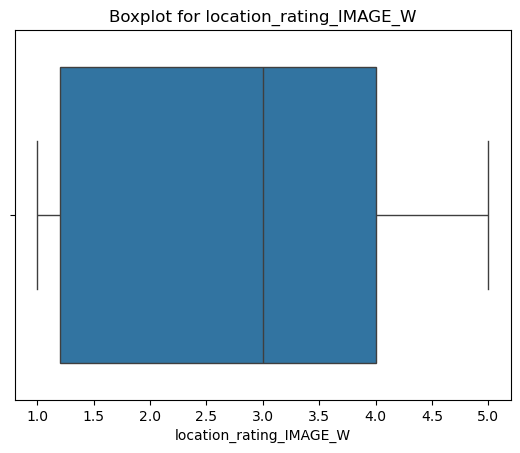

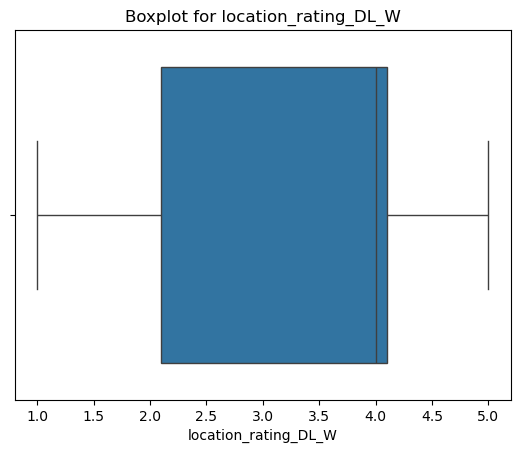

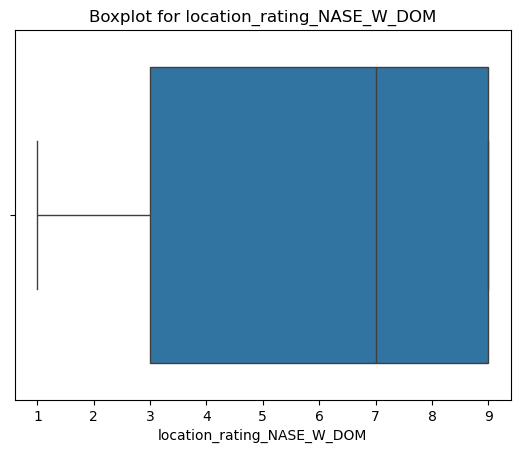

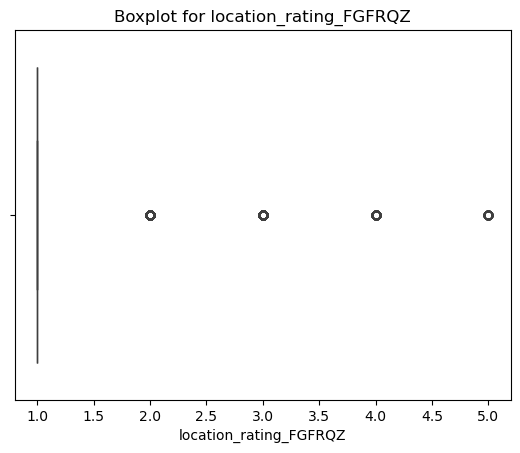

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Построение boxplot для каждого рейтинга
for col in rating_columns:
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot for {col}')
    plt.show()

In [15]:
# Функция для удаления выбросов
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Применяем функцию к каждому рейтингу
for col in rating_columns:
    df = remove_outliers(df, col)

In [17]:
# Предположим, что рейтинги должны быть от 1 до 5
for col in rating_columns:
    df = df[(df[col] >= 1) & (df[col] <= 5)]

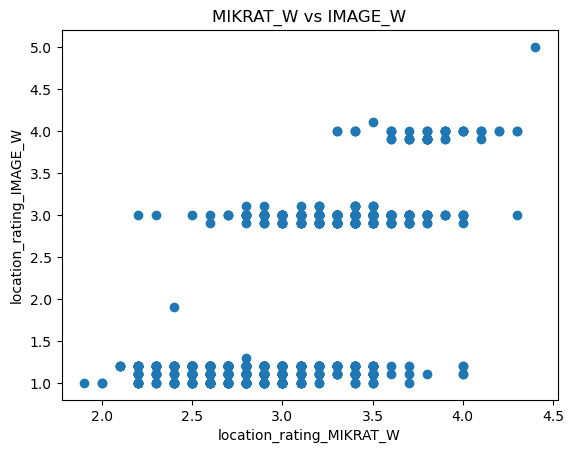

In [19]:
# Построим график зависимости между двумя рейтингами
plt.scatter(df['location_rating_MIKRAT_W'], df['location_rating_IMAGE_W'])
plt.xlabel('location_rating_MIKRAT_W')
plt.ylabel('location_rating_IMAGE_W')
plt.title('MIKRAT_W vs IMAGE_W')
plt.show()

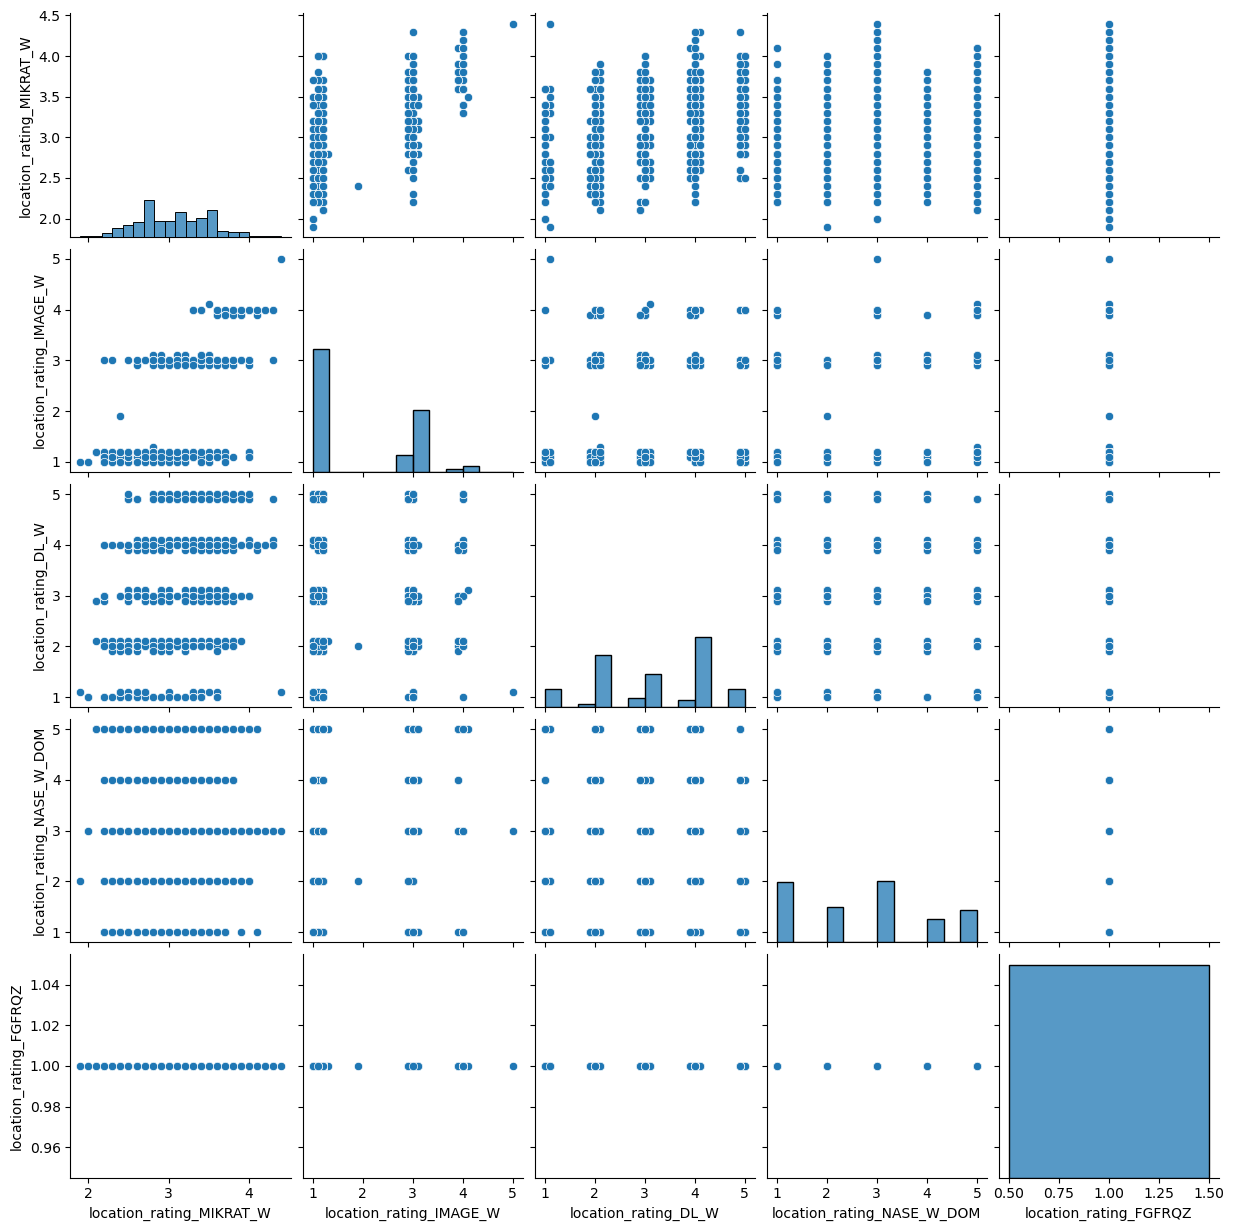

In [21]:
# Используем seaborn для парных графиков
sns.pairplot(df[rating_columns])
plt.show()

C:\Users\kettl\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\kettl\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\kettl\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\kettl\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

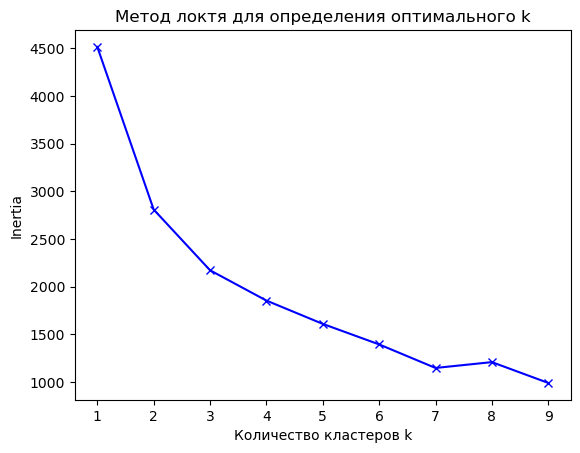

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[rating_columns])

from sklearn.cluster import KMeans

inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bx-')
plt.xlabel('Количество кластеров k')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения оптимального k')
plt.show()

In [41]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

kmeans = KMeans(
    n_clusters=3,
    init='k-means++',  # Стандартная инициализация
    n_init=10,
    max_iter=300,
    random_state=42
)
kmeans.fit(X_scaled)
df['cluster'] = kmeans.labels_

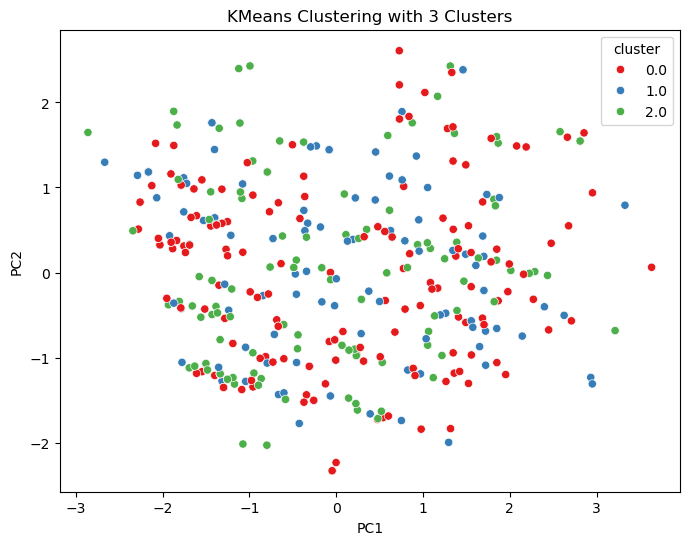

In [43]:
# Используем PCA для снижения размерности до 2D для визуализации
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])
df_pca['cluster'] = df['cluster']

# Построение графика
plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca, palette='Set1')
plt.title('KMeans Clustering with 3 Clusters')
plt.show()

'''
Вывод: 
1. Был создан новый атрибут average_location_rating, представляющий собой средний рейтинг локации для каждого здания. Это позволило получить обобщенную оценку качества локации, учитывая все доступные рейтинги.
2. Пропущенные значения были удалены. Были обнаружены и удалены дубликаты, что улучшило качество данных. Выбросы в данных были идентифицированы и устранены с использованием межквартильного размаха, что помогло избежать искажений в анализе.
3. Построение графиков рассеяния между различными рейтингами показало наличие групп зданий с похожими рейтингами. Выявлены кластеры, которые могут соответствовать разным категориям зданий.
4. Метод локтя указал на оптимальное количество кластеров равное 3. Применение KMeans позволило разделить здания на три кластера на основе их рейтингов. Анализ кластеров может помочь в сегментации зданий для дальнейшего маркетинга или улучшения качества услуг.
'''